This notebook goes through a simple binary classification example, explaining general library functionality and loading along the way.

We perform binary classification on sex, using structural MRI rois.

# Init Phase

In [1]:
from ABCD_ML import ABCD_ML, Load
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


The following definition are useful simply as a shorthand for defining long file paths all in one place.

In [2]:
# Base data directories
nda_dr = '/mnt/sdb2/ABCD2p0NDA/'
nda_dr2 = '/mnt/sdb2/ABCDFixRelease2p0p1/'

#This file stores the name mapping
map_file = os.path.join(nda_dr2, 'Fix Release Notes 2.0.1_Public', '24. ABCD_Release_2.0.1_Updates',
                        'abcd_2.0.1_mapping.csv')

# Destr atlas structural MRI rois
data1 = os.path.join(nda_dr2, 'abcd_mrisdp101.txt')
data2 = os.path.join(nda_dr2, 'abcd_mrisdp201.txt')

# Family ID
strat1 = os.path.join(nda_dr, 'acspsw03.txt')

We first need to define the class object, which we will use to load load and to train/test different ML models.
There are a few global parameters which we can optionally set when defining this object as well, lets look and see what they are.

In [3]:
help(ABCD_ML.__init__)

Help on function __init__ in module ABCD_ML.main.ABCD_ML:

__init__(self, exp_name='Exp', log_dr='', existing_log='append', verbose=True, notebook=True, use_default_subject_ids=False, low_memory_mode=False, strat_u_name='_Strat', random_state=None)
    Main class init
    
    Parameters
    ----------
    exp_name : str, optional
        The name of this experimental run,
        used explicitly in saving logs, and figures.
        If log_dr is not set to None-
        (if not None then saves logs and figures)
        then a folder is created within the log dr
        with the exp_name.
    
        (default = 'Exp')
    
    log_dr : str, Path or None, optional
        The directory in which to store logs...
        If set to None, then will not save any logs!
        If set to '', will save in the current dr.
    
        (default = '')
    
    existing_log : {'new', 'append', 'overwrite'}, optional
        By default, if an exp_name folder already
        exists within the log_dr,

Most of the default parameters are okay for this simple example, but any of them can be changed.

In [4]:
ML = ABCD_ML(exp_name = 'Sex',
             existing_log = 'overwrite',
             use_default_subject_ids = True,
             random_state = 1)

exp_name = Sex
log_dr = /home/sage/ABCD_ML/Examples
existing_log = overwrite
verbose = True
exp log dr setup at: /home/sage/ABCD_ML/Examples/Sex
log file at: /home/sage/ABCD_ML/Examples/Sex/logs.txt
notebook = True
use_default_subject_ids = True
low memory mode = False
strat_u_name = _Strat
random state = 1
ABCD_ML object initialized


# Loading Phase

First we will consider setting default parameters for loading.

In [5]:
help(ML.Set_Default_Load_Params)

Help on method Set_Default_Load_Params in module ABCD_ML.main._Data:

Set_Default_Load_Params(dataset_type='default', subject_id='default', eventname='default', eventname_col='default', overlap_subjects='default', na_values='default', drop_na='default', drop_or_na='default') method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    This function is used to define default values for a series of
    params accessible to all or most of the different loading functions.
    By setting common values here, it reduces the need to repeat params within
    each loader (e.g. Load_Data, Load_Targets, ect...)
    
    Parameters
    ----------
    dataset_type : {'basic', 'explorer', 'custom'}, optional
        The dataset_type / file-type to load from.
        Dataset types are,
    
        - 'basic'
            ABCD2p0NDA style (.txt and tab seperated).
            Typically the default columns, and therefore not neuroimaging
            data, will be dropped, also not including the eventname column.


In [6]:
ML.Set_Default_Load_Params(dataset_type = 'basic',
                           eventname = 'baseline_year_1_arm_1',
                           eventname_col = 'eventname',
                           drop_na = True)

No default subject_id passed, set to "src_subject_id"
No default overlap_subjects passed, set to False
No default na_values passed, set to ["777", "999"]
No default drop_or_na passed, set to "drop"
Default load params set within self.default_load_params.



We can continue by optionally loading in a name map, which is simply a dictionary that attempts to rename any column names loaded in, if those column names are a key in the dictionary. This is useful for ABCD data as the default column names might not be useful. This mapping was provided along with the 2.0.1 data release.

In [7]:
ML.Load_Name_Map(loc = map_file,
                 dataset_type = 'explorer',
                 source_name_col = 'nda_name',
                 target_name_col = 'deap_name')

Loading /mnt/sdb2/ABCDFixRelease2p0p1/Fix Release Notes 2.0.1_Public/24. ABCD_Release_2.0.1_Updates/abcd_2.0.1_mapping.csv  with dataset type: explorer
Loading new name_map from file!


We can look at what exactly is in this dictionary if we want to confirm we loaded it correctly.
It is loaded as name_map within the ABCD_ML class.

In [8]:
some_examples = {k: ML.name_map[k] for k in list(ML.name_map)[300:320]}
some_examples

{'ddtidp_119': 'dmri_dti.fa.wm_cort.destrieux_s.central.rh',
 'ddtidp_120': 'dmri_dti.fa.wm_cort.destrieux_s.cingul.marginalis.rh',
 'ddtidp_121': 'dmri_dti.fa.wm_cort.destrieux_s.circular.insula.ant.rh',
 'ddtidp_122': 'dmri_dti.fa.wm_cort.destrieux_s.circular.insula.inf.rh',
 'ddtidp_123': 'dmri_dti.fa.wm_cort.destrieux_s.circular.insula.sup.rh',
 'ddtidp_124': 'dmri_dti.fa.wm_cort.destrieux_s.collat.transv.ant.rh',
 'ddtidp_125': 'dmri_dti.fa.wm_cort.destrieux_s.collat.transv.post.rh',
 'ddtidp_126': 'dmri_dti.fa.wm_cort.destrieux_s.front.inf.rh',
 'ddtidp_127': 'dmri_dti.fa.wm_cort.destrieux_s.front.middle.rh',
 'ddtidp_128': 'dmri_dti.fa.wm_cort.destrieux_s.front.sup.rh',
 'ddtidp_129': 'dmri_dti.fa.wm_cort.destrieux_s.interm.prim.jensen.rh',
 'ddtidp_130': 'dmri_dti.fa.wm_cort.destrieux_s.intrapariet.and.p.trans.rh',
 'ddtidp_131': 'dmri_dti.fa.wm_cort.destrieux_s.oc.middle.and.lunatus.rh',
 'ddtidp_132': 'dmri_dti.fa.wm_cort.destrieux_s.oc.sup.and.transversal.rh',
 'ddtidp_133':

The next step to consider is in if there are any subjects which should be apriori excluded. These can be defined as either a list of subjects to exclude, or as a list of subjects to include (where only those subjects that appear in the list would be kept).

See:

- https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-exclusions

- https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-inclusions

In this example we will not define any.

Next, we will load in the actual data of interest. You will note when looking at the help function that all of the parameter we set in the defaults can also be set here as well, or if we want to keep the default params, we just leave the values as is.


In [9]:
help(ML.Load_Data)

Help on method Load_Data in module ABCD_ML.main._Data:

Load_Data(loc=None, df=None, dataset_type='default', drop_keys=None, inclusion_keys=None, subject_id='default', eventname='default', eventname_col='default', overlap_subjects='default', na_values='default', drop_na='default', drop_or_na='default', filter_outlier_percent=None, filter_outlier_std=None, unique_val_drop=None, unique_val_warn=0.05, drop_col_duplicates=None, clear_existing=False) method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    Class method for loading ROI-style data, assuming all loaded
    columns are continuous / float datatype.
    
    Parameters
    ----------
    loc : str Path, list of or None, optional
        The location of the file to load data load from.
        If passed a list, then will load each loc in the list,
        and will assume them all to be of the same dataset_type if one
        dataset_type is passed, or if they differ in type, a list must be
        passed to dataset_type with the differ

In [10]:
ML.Load_Data(loc = [data1, data2])

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 0 cols for all missing values
Dropped 2892 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

Processing unique col values with drop threshold: 0 - warn threshold: 432.1 - out of 8642 rows
Warn - smri_area_cort.destrieux_g.front.inf.orbital.lh has unique vals: 300
Warn - smri_area_cort.destrieux_g.ins.lg.and.s.cent.ins.lh has unique vals: 350
Warn - 

By default the loading data function has warned us about some columns with a suspiciously low number of unique values, and also note that they are all surface area, so maybe that is expected. Lets turn warn off in the future

The other alarming thing to note is we are losing 2892 rows for missing values. One way we can examine this further is to re-load the data, but without dropping any missing values.

In [11]:
ML.Load_Data(loc = [data1, data2],
             unique_val_warn = None,
             drop_na = False,
             clear_existing = True # Make sure to call clear_existing if re-loading the same data!
             )

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 0 cols for all missing values
Loaded rows with NaN remaining: 2892

Loaded NaN Info:
There are: 284244 total missing values
437 columns found with 4 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
435 columns found with 617 missing values (column name overlap: ['_cort.destrieux_', 'smri_t2w.'])
18 columns found with 1 missing values (column name overlap: ['_cort.destrieux_', 'smri_']

Now we are provided some more detailed information about what NaN columns are loaded. This is useful because we can note there are 435 columns found with 617 missing values, and of those 435 columns, 'smri_t2w.' is one of the keys present in all of them. In this case, what we can do is try not loading t2w rois, as it is clear some number of subjects just didn't get a t2 scan. 

In [12]:
ML.Load_Data(loc = [data1, data2],
             unique_val_warn = None,
             drop_keys = 'smri_t2w.',
             drop_na = False,
             clear_existing = True
             )

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 453 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Loaded rows with NaN remaining: 2396

Loaded NaN Info:
There are: 4680 total missing values
437 columns found with 4 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
18 columns found with 1 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
12 columns found with 5 missing values (column na

We now have a few different options for how we want to handle the rest of the NaN's. The first is to either just drop all of them, but as evident by 437 columns found with 4 missing values, it might be the case that there are just a few subjects with a messed up scan, and therefore a bunch of NaN's. We can try setting drop_nan to 10. In that case, only subjects with less then or equal to 10 NaNs will be kept.

In [13]:
ML.Load_Data(loc = [data1, data2],
             unique_val_warn = None,
             drop_keys = 'smri_t2w.',
             drop_na = 10,
             clear_existing = True
             )

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 453 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Dropped 12 rows for missing values, based on the provided drop_na param: 10 with actual na_thresh: 10
Loaded rows with NaN remaining: 2384

Loaded NaN Info:
There are: 2697 total missing values
12 columns found with 1 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
7 columns found with 2 missing values (c

Okay great. Now we have 2384 subjects with atleast one NaN value to impute, but we know that all of those subjects only have 1-10 missing values, and likewise, no single feature seems to have all that many NaN's. We now have 11522 subjects and still 1057 features.

Let's also keep track of these subjects with missing values, we can do something a little fancy later on.

In [14]:
na_mask = pd.isnull(ML.data).any(axis=1)
na_subjects = na_mask[na_mask].index
na_subjects.shape

(2384,)

We can check the data distribution visually too for a few random ROIs.

In [15]:
ML.Show_Data_Dist()

Set to overlapping loaded subjects.
Loaded data top columns by skew:
smri_t1w.white02_cort.destrieux_s.suborbital.lh           -3.112686
smri_sulc_cort.destrieux_s.parieto.occipital.rh           -2.920822
smri_t1w.white02_cort.destrieux_g.and.s.frontomargin.rh   -2.824686
smri_t1w.white02_cort.destrieux_s.cingul.marginalis.rh    -2.728025
smri_t1w.white02_cort.destrieux_s.orbital.h.shaped.rh     -2.576301
                                                             ...   
smri_sulc_cort.destrieux_g.postcentral.lh                  3.265920
smri_sulc_cort.destrieux_g.postcentral.rh                  3.921561
smri_area_cort.destrieux_g.cingul.post.ventral.rh          4.879144
smri_area_cort.destrieux_g.cingul.post.ventral.lh          4.884233
smri_vol_cort.destrieux_g.cingul.post.ventral.lh           5.522184
Length: 1057, dtype: float64


There does not appear to be too many big outliers in the dataset, lets avoid doing any outlier dropping in this example, and instead if it is a problem deal with it during modelling. In general, there are a number of methods for dropping outliers or performing other proc on the loaded data either built into Load_Data or as an external function, e.g., Proc_Data_Unique_Cols https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#proc-data-unique-cols

We will load our target variable next.

In [16]:
help(ML.Load_Targets)

Help on method Load_Targets in module ABCD_ML.main._Data:

Load_Targets(loc=None, df=None, col_name=None, data_type=None, dataset_type='default', subject_id='default', eventname='default', eventname_col='default', overlap_subjects='default', filter_outlier_percent=None, filter_outlier_std=None, categorical_drop_percent=None, na_values='default', clear_existing=False) method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    Loads in targets, the outcome / variable(s) to predict.
    
    Parameters
    ----------
    loc : str, Path or None, optional
        The location of the file to load targets load from.
    
        Either loc or df must be set, but they both cannot be set!
    
        (default = None)
    
    df : pandas DataFrame or None, optional
        This parameter represents the option for the user to pass in
        a raw custom dataframe. A loc and/or a df must be passed.
    
        When pasing a raw DataFrame, the loc and dataset_type
        param will be ignored, as th

Again, a number of the default load params are accesible when loading targets too in case they need to change. We again need to only use fairly simple functionality here, loading in the sex column from our structural mris (as some bugs with sex were fixed in release 2.0.1). 

In [17]:
ML.Load_Targets(loc=data1,
                col_name='sex',
                data_type='b')

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 1 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

loading: sex

Final shape:  (11533, 1)

Total valid overlapping subjects = 11521

All loaded targets
0 : sex



Set to overlapping loaded subjects.
-- sex --


,Original Name,Counts,Frequency
Internal Name,,,
0,F,5483,0.475914
1,M,6038,0.524086


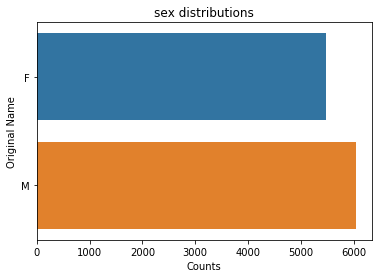

In [18]:
ML.Show_Targets_Dist()

One thing to note when plotting the Show_Targets_Dist is the printed "Set to overlapping loaded subjects.", which means we are only seeing the targets distribution based on the overlap of all subjects currently loaded (so right now that is just the overlap with data). This can be set off in the case we want to see, in this case, the few subjects who will be eventually lost.

We can look into adding covars next. Where co-variates arn't quite treated as typical co-variates, but are values we would like to be able to pass as additional input to the ML model if desired (and input that can be treated specially). This example will actually skip this step though.

Lastly, we will considering loading different stratification values. These are the values that we can optionally define custom validation / split behavior on. Within this example, we are just going to make sure that all splits preserve subjects with the same family id within the same fold, so lets load family id - after looking as the help function.

In [19]:
help(ML.Load_Strat)

Help on method Load_Strat in module ABCD_ML.main._Data:

Load_Strat(loc=None, df=None, col_name=None, dataset_type='default', subject_id='default', eventname='default', eventname_col='default', overlap_subjects='default', binary_col=False, float_col=False, float_bins=10, float_bin_strategy='uniform', categorical_drop_percent=None, na_values='default', clear_existing=False) method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    Load stratification values from a file.
    See Notes for more details on what stratification values are.
    
    Parameters
    ----------
    loc : str, Path or None, optional
        The location of the file to load stratification vals load from.
    
        Either loc or df must be set, but they both cannot be set!
    
        (default = None)
    
    df : pandas DataFrame or None, optional
        This parameter represents the option for the user to pass in
        a raw custom dataframe. A loc and/or a df must be passed.
    
        When pasing a raw Data

In [20]:
ML.Load_Strat(loc=strat1,
              col_name='rel_family_id')

Loading /mnt/sdb2/ABCD2p0NDA/acspsw03.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 2 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

Total valid overlapping subjects = 11519



Great, we now have all the data we will need loaded (Noting that the minimum requiriments for running an ML expiriment are just data or covars and targets, the rest being optional). The actual length of the script is also not as terrible as it seems, and once loading behavior is confirmed, verbose can even be turned off. In practice also, there is no reason why the user should not just keep reloading data, with changes to params, within the same cell by re-running it - which would defeat the point of a tutorial, but would greatly help readability!

# Validation Phase

Lets move onto defining our validation stratagy (which is again optional, but as stated before for this example we are going to preserve family ids within the same folds), if no explicit validation strategy is defined, then random splits will be used. 

In [21]:
help(ML.Define_Validation_Strategy)

Help on method Define_Validation_Strategy in module ABCD_ML.main._Validation:

Define_Validation_Strategy(groups=None, stratify=None, train_only_loc=None, train_only_subjects=None, show=True, show_original=True) method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    Define a validation strategy to be used during different train/test
    splits, in addition to model selection and model hyperparameter CV.
    See Notes for more info.
    
    Parameters
    ----------
    groups : str, list or None, optional
        In the case of str input, will assume the str to refer
        to a column key within the loaded strat data,
        and will assign it as a value to preserve groups by
        during any train/test or K-fold splits.
        If a list is passed, then each element should be a str,
        and they will be combined into all unique
        combinations of the elements of the list.
    
        (default = None)
    
    stratify : str, list or None, optional
        In the case of s

So for group preserving behavior, as we are interested in keep families within the same folds, we supply an argument for groups. Specifically, we use the name of the column loaded within self.strat

Notably as well is that defining a validation strategy is used to define global split behavior, which means the defined validation behavior will effect the train test split, as well as the internal splits used in modelling. Therefore, if we want to do something a bit more complicated, say treat as any subject with a missing value as a train only subject, just for the gloabl train test split - to ensure we have a "pure" test set, but then during modelling, not worry about them, then we have to do an extra step (which for the record that is the exact plan). We just need to do an extra step. First we define our family id preserving val strategy with the additional train_only_subjects param, then once we call Train_Test_Split, we will just redfine the validation strategy w/o the train only subjects.

Notably also, we can re-define the original validation strategy at any point (why? in order to test within just the train set the effect of putting all the subjects with any nan as train only)

In [22]:
# Also note new functionality! Instead of passing na_subjects, can just pass 'nan' to automatically select
# all subjects with NaN
ML.Define_Validation_Strategy(groups='rel_family_id', train_only_subjects=na_subjects)


Total valid overlapping subjects = 11519
Removing non overlapping subjects from loaded data, covars, ect...

2384 Train only subjects defined.
Those subjects are excluded from the below stats!

CV defined with group preserving over 8029 unique values.


Lastly before we get to modelling, we want to define a global train-test split, so that we can perform model exploration, and parameter tuning ect... on a training set, and leave a left-out testing set to eventually test with out final selected model.

In [23]:
help(ML.Train_Test_Split)

Help on method Train_Test_Split in module ABCD_ML.main._Validation:

Train_Test_Split(test_size=None, test_loc=None, test_subjects=None, random_state='default') method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    Define the overarching train / test split, *highly reccomended*.
    
    Parameters
    ----------
    test_size : float, int or None, optional
        If float, should be between 0.0 and 1.0 and represent
        the proportion of the dataset to be included in the test split.
        If int, represents the absolute number (or target number) to
        include in the testing group.
        Set to None if using test_loc or test_subjects.
    
        (default = None)
    
    test_loc : str, Path or None, optional
        Location of a file to load in test subjects from.
        The file should be formatted as one subject per line.
    
        (default = None)
    
    test_subjects : list, set, array-like or None, optional
        An explicit list of subjects to constitute t

In [24]:
ML.Train_Test_Split(test_size=.35) #Lets use .35, as train only subjects will not be considered

Preparing final data, in self.all_data
Any changes to loaded data, covars or strat will not be included, from now on.

Final data (w/ target) for modeling loaded shape: (11519, 1059)
Performing split on 8516 subjects with 3003 considered train only!
Test split size: 0.35

Performed train test split!
Train size: 8549
Test size:  2970


Note above for the curious, 3003 subjects are considered train only, event though we only had 2384 with NaN. This is because we are defining group preserving behavior on family id, so not only do we need to keep those subjects in the training set, but keep all of their family members. We know now that no family id is in both the train and test set - but for the paranoid we can make sure of this.

In [25]:
train_ids = set(ML.strat['rel_family_id_Strat'].loc[ML.train_subjects])
test_ids = set(ML.strat['rel_family_id_Strat'].loc[ML.test_subjects])

print('Unique family ids in train: ', len(train_ids))
print('Unique family ids in test: ', len(test_ids))
print('Overlap : ', len(train_ids.intersection(test_ids)))

Unique family ids in train:  7123
Unique family ids in test:  2600
Overlap :  0


As mentioned before, we now want to go back to back to the behavior where na subjects are not given any different treatment. Since the train test split is already defined, we can change the validation behavior, and therefore the CV behavior during Evaluate and modelling, as we wish.

In [26]:
ML.Define_Validation_Strategy(groups='rel_family_id')


Total valid overlapping subjects = 11519
Removing non overlapping subjects from loaded data, covars, ect...

CV defined with group preserving over 9723 unique values.


Here might also be a good time to save a copy of the object we have created, if that is desired behavior. We are going to save it in our defined log_dr, and use the low_memory flag, which doesn't save explicitly loaded self.data, self.covars ect... and just stores the final self.all_data for modelling (which we have already implicitly created). Let's try it out.

In [27]:
save_loc = os.path.join(ML.exp_log_dr, 'Sex.ML')
ML.Save(save_loc, low_memory=True)

In [28]:
del ML
ML = Load(save_loc)

ABCD_ML object loaded from save!


To try this out, we can delete our loaded ML object and re-load the saved one

# Modeling Phase

The first step of modeling, is to define some default values, yay. There are admittedly a lot, but most can be ignored, and tend to offer optional functionality. Lets look through.

In [29]:
help(ML.Set_Default_ML_Params)

Help on method Set_Default_ML_Params in module ABCD_ML.main._ML:

Set_Default_ML_Params(problem_type='default', target='default', model='default', model_params='default', metric='default', imputer='default', imputer_scope='default', imputer_params='default', scaler='default', scaler_scope='default', scaler_params='default', sampler='default', sample_on='default', sampler_params='default', feat_selector='default', feat_selector_params='default', ensemble='default', ensemble_split='default', ensemble_params='default', splits='default', n_repeats='default', search_type='default', search_splits='default', search_n_iter='default', feats_to_use='default', subjects_to_use='default', feat_importances='default', feat_importances_params='default', n_jobs='default', random_state='default', compute_train_score='default', cache='default', extra_params='default') method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    Sets self.default_ML_params dictionary with user passed or default
    values. In gene

In [30]:
# Only will set ones that change below, all other ones are left as default.

ML.Set_Default_ML_Params(problem_type = 'binary', # Easy choice...
                         metric = ['matthews', 'roc auc'], # Good thresholded and non-thresholded binary metrics
                         scaler = 'robust',
                         search_n_iter = 30,
                         n_jobs = 8)

No default target passed, set to 0.
No default model type passed, set to linear.
No default imputer passed, set to [mean, median]
No default imputer scope passed, set to [float, categorical]
No default scaler_scope passed, set to data
No default sampler passed, set to None
No default sample on passed, set to targets
No default feat selector passed, set to None
No default splits passed, set to 3
No default num CV repeats passed, set to 2
No default num search splits passed, set to 3
No default ensemble type passed, set to basic ensemble
No default ensemble split passed, set to .2
No default search type passed, set to None
No default model param ind passed, set to 0
No default imputer scaler params passed, set to 0
No default data scaler params passed, set to 0
No default sampler params passed, set to 0
No default feat selector params passed, set to 0
No default ensemble type params passed, set to 0
No default feats_to_use passed, set to all
No default subjects_to_use passed, set to all


Now we can proceed to modeling.


The main function we use here is Evaluate. We won't bother looking at the help str as it has all of the same params as we just saw above, allowing you to proceed to with differing specific choices in addition to all set default values. Evaluate does have one unique param though, and that is run_name, which is the name in which the results of each run will be stored under in ML.eval_scores.

We check what different model types we have avaliable also.

In [31]:
ML.Show_Models(problem_type='binary')

Visit the sklearn documentation for more info on most of the dif. models
Note: Param distributions with a Rand Distribution
cannot be used in search_type = "grid"
More information through this function is avaliable
By passing optional extra optional params! Please view the help function for more info!
Note: the str indicator actually passed during Evaluate / Test
is listed as ("str indicator")

Avaliable for Problem Type: binary
----------------------------------------


- - - - - - - - - - - - - - - - - - - - 
DecisionTreeClassifier ("dt classifier")
- - - - - - - - - - - - - - - - - - - - 



- - - - - - - - - - - - - - - - - - - - 
LogisticRegression ("elastic net logistic")
- - - - - - - - - - - - - - - - - - - - 



- - - - - - - - - - - - - - - - - - - - 
GaussianNB ("gaussian nb")
- - - - - - - - - - - - - - - - - - - - 



- - - - - - - - - - - - - - - - - - - - 
GaussianProcessClassifier ("gp classifier")
- - - - - - - - - - - - - - - - - - - - 



- - - - - - - - - - - - - - 

We can also look at different metrics and scalers ect... with the "Show" style functions, but I generally prefer the interface on the documentation. E.g., https://abcd-ml.readthedocs.io/en/latest/options.html#id20

Now that we have some default ML params set, all we need to do to run an evaluation is simply: (for a just linear regression).

In [32]:
raw_scores, raw_preds, FIs = ML.Evaluate(model='linear')

Setting default ML verbosity settings!
Note, if the following values are not desired, call self.Set_Default_ML_Verbosity()
No default progress bar passed, set to True.
No default fold name passed, set to False.
No default time per fold passed, set to False.
No default score per fold passed, set to False.
No default fold sizes passed, set to False.
No default save to logs passed, set to False.

Running Evaluate with:
target = 0
problem_type = binary
model = linear
model_params = 0
metric = ['matthews', 'roc auc']
imputer = ['mean', 'median']
imputer_scope = ['float', 'categorical']
imputer_params = 0
scaler = robust
scaler_scope = data
scaler_params = 0
sampler = None
feat_selector = None
splits = 3
n_repeats = 2
search_type = None
n_jobs = 8
feats_to_use = all
subjects_to_use = all
compute_train_score = False
random_state = 1
feat_importances = base
feat_importances_params = 0
cache = None
extra_params = {}

Saving scores and settings with unique name: linear




Validation Scores
_________________
Metric:  matthews
Mean Validation score:  0.6961468321744961
Macro Std in Validation score:  0.0019161639597889413
Micro Std in Validation score:  0.012196246463804732

Metric:  macro roc auc
Mean Validation score:  0.9237343918024494
Macro Std in Validation score:  1.805464554455183e-05
Micro Std in Validation score:  0.002610337790053501



Note the message about Set_Default_ML_Verbosity(). In addition to the progress bar, there are a number of optional extra parameters which can be set during modelling to see different levels of verbose output.

Lets try with multiple data scalers now, just to show off that functionality, and still just the logistic regression.

In [ ]:
raw_scores, raw_preds, FIs = ML.Evaluate(model='logistic', # linear / logistic are equivilent here
                                         scaler = ['robust', 'minmax'])

What we will look at next is just a quick example showing some of the different ways of calculating feature importance, but we'll use just an light gbm model with no param search for everything to run quick

In [ ]:
raw_scores, raw_preds, FIs = ML.Evaluate(model='light gbm',
                                         scaler = 'robust',
                                         feat_importances = ['perm', 'shap', 'base'],
                                         n_repeats=1)

Running Evaluate with:
target = 0
problem_type = binary
model = light gbm
model_params = 0
metric = ['matthews', 'roc auc']
imputer = ['mean', 'median']
imputer_scope = ['float', 'categorical']
imputer_params = 0
scaler = robust
scaler_scope = data
scaler_params = 0
sampler = None
feat_selector = None
splits = 3
n_repeats = 1
search_type = None
n_jobs = 8
feats_to_use = all
subjects_to_use = all
compute_train_score = False
random_state = 1
feat_importances = ['perm', 'shap', 'base']
feat_importances_params = 0
cache = None
extra_params = {}

Saving scores and settings with unique name: light gbm



In [ ]:
ML.Plot_Global_Feat_Importances(FIs[0], top_n=10, show_abs=True)

In [ ]:
ML.Plot_Global_Feat_Importances(FIs[1], top_n=10, show_abs=True)

In [ ]:
ML.Plot_Global_Feat_Importances(FIs[2], top_n=10, show_abs=True)

In [ ]:
ML.Plot_Global_Feat_Importances(FIs[0], top_n=10, show_abs=True)